In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import numpy as np
import random

2025-02-12 11:43:04.507139: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 11:43:04.508575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 11:43:04.536169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 11:43:04.536877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 11:43:05.195476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
train_patches = np.load("train_patches_17.npy")
target_patches = np.load("target_patches_17.npy")
patch_size = 17

In [3]:

X_train, X_test, y_train, y_test = train_test_split(train_patches, target_patches, test_size=0.2, random_state=42)


In [4]:
X_train.shape

(13600, 7, 17, 17)

In [5]:
# Reshape the input data if necessary
X_train = X_train.transpose(0, 2, 3, 1)  # Reorder to (num_samples, 32, 32, 7)
X_test = X_test.transpose(0, 2, 3, 1)    # Reorder to (num_samples, 32, 32, 7)

In [6]:
def build_cnn_model(patch_size, num_bands=7):
    model = models.Sequential()
    
    # First Conv Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, num_bands)))
    model.add(layers.MaxPooling2D((2, 2)))  # Reduces size by half

    # Second Conv Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Only apply pooling if spatial size is still sufficient
    if patch_size >= 17:
        model.add(layers.MaxPooling2D((2, 2)))  # Further reduces size

    # Third Conv Layer (check spatial size before applying)
    if patch_size >= 33:
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    # Use GlobalAveragePooling for small patches to avoid invalid Conv2D shapes
    if patch_size in [9, 17]:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

In [7]:
model = build_cnn_model(patch_size)

In [8]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/12
425/425 [==============================] - 1s 2ms/step - loss: 12.2113 - accuracy: 0.7194 - val_loss: 0.8885 - val_accuracy: 0.7406
Epoch 2/12
425/425 [==============================] - 1s 2ms/step - loss: 1.0047 - accuracy: 0.7445 - val_loss: 0.5841 - val_accuracy: 0.8276
Epoch 3/12
425/425 [==============================] - 1s 2ms/step - loss: 0.7241 - accuracy: 0.7611 - val_loss: 0.6053 - val_accuracy: 0.7597
Epoch 4/12
425/425 [==============================] - 1s 2ms/step - loss: 0.5175 - accuracy: 0.7902 - val_loss: 0.4792 - val_accuracy: 0.8044
Epoch 5/12
425/425 [==============================] - 1s 2ms/step - loss: 0.5345 - accuracy: 0.7825 - val_loss: 0.5096 - val_accuracy: 0.8041
Epoch 6/12
425/425 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.7969 - val_loss: 0.4724 - val_accuracy: 0.8132
Epoch 7/12
425/425 [==============================] - 1s 2ms/step - loss: 0.5145 - accuracy: 0.7860 - val_loss: 0.4777 - val_accuracy: 0.8203
Epoch

In [9]:
model = models.Sequential([
    # The input shape should be (33, 33, 7) for patches with 7 bands
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, 7)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (High/Low UHI)
])




ValueError: Exception encountered when calling layer "conv2d_4" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_4/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_4/Conv2D/ReadVariableOp)' with input shapes: [?,2,2,64], [3,3,64,128].

Call arguments received by layer "conv2d_4" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 2, 2, 64), dtype=float32)

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

107/107 [==============================] - 0s 605us/step - loss: 0.5197 - accuracy: 0.7756
Test Loss: 0.5196964144706726
Test Accuracy: 0.7755882143974304


In [10]:
# Make predictions
y_pred = model.predict(X_test)

# If you want to visualize or further analyze the predictions
print(y_pred.shape)  # Should be (num_samples, 32, 32) as you're predicting UHI


107/107 [==============================] - 0s 653us/step
(3400, 1)


In [11]:
from sklearn.metrics import accuracy_score

# Flatten y_test and y_pred to 1D arrays for comparison
y_test_flat = y_test.flatten()
y_pred_flat = (y_pred.flatten() > 0.7).astype(int)  # Assuming binary classification

accuracy = accuracy_score(y_test_flat, y_pred_flat)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8126470588235294


In [12]:
def plot_bands_per_result(random_idx):
    import matplotlib.colors as mcolors

    # Define the color ramp from the provided dictionary
    color_dict = {
        1: "#828282",  # Residential urban areas
        2: "#4c0073",  # Industrial and abandoned urban areas
        3: "#ff0000",  # Transportation infrastructure
        4: "#00a884",  # Urban green areas
        5: "#ffffbe",  # Agricultural areas
        6: "#aaff00",  # Forest
        7: "#00a9e6",  # Humid areas
        #9999: "#ffffff"  # No data
    }

    # Define the class labels
    class_labels = {
        1: "Residential urban areas",
        2: "Industrial and abandoned urban areas",
        3: "Transportation infrastructure",
        4: "Urban green areas",
        5: "Agricultural areas",
        6: "Forest",
        7: "Humid areas",
        8: ""
        #9999: "No data"
    }

    # Create a custom colormap based on the color_dict
    cmap = mcolors.ListedColormap([color for color in color_dict.values()])

    # Create a norm to scale the data to the colormap
    bounds = list(color_dict.keys()) + [max(color_dict.keys()) + 1]  # Use the keys as the bounds (1, 2, 3, ..., 9999)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=(30, 10))  # Increase the figure size to fit 3 plots side by side

    # Plot for Band 0
    plt.subplot(1, 3, 1)
    im0 = plt.imshow(X_test[random_idx, :, :, 0], cmap='YlOrRd')  # Display band 0 (33x33)
    plt.title('LST', fontsize= 20)  # Title with predicted value
    plt.colorbar(im0, label="LST Value (K)")

    # Plot for Band 1
    plt.subplot(1, 3, 2)
    im1 = plt.imshow(X_test[random_idx, :, :, 1], cmap='Greens')  # Display band 1 (33x33)
    plt.title("NDVI", fontsize= 20)
    plt.colorbar(im1, label="NDVI (-1:1)")

    # Plot for Band 6
    plt.subplot(1, 3, 3)
    im6 = plt.imshow(X_test[random_idx, :, :, 6], cmap=cmap, norm=norm)  # Display band 6 with custom colormap
    plt.title("Land cover", fontsize= 20)
    landcover_colorbar = plt.colorbar(im6, ticks=bounds, label="Land Use Categories")  # Custom colorbar with labels
    landcover_colorbar.set_ticks(bounds)  # Set the ticks for the colorbar to be the class numbers
    landcover_colorbar.set_ticklabels([class_labels[b] for b in bounds])  # Set the labels for each tick

    # Set the overall title for the plot
    plt.suptitle(f"SUHI value: {y_pred_flat[random_idx]} (probability: {y_pred[random_idx]})", fontsize=16)

    # Show the plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


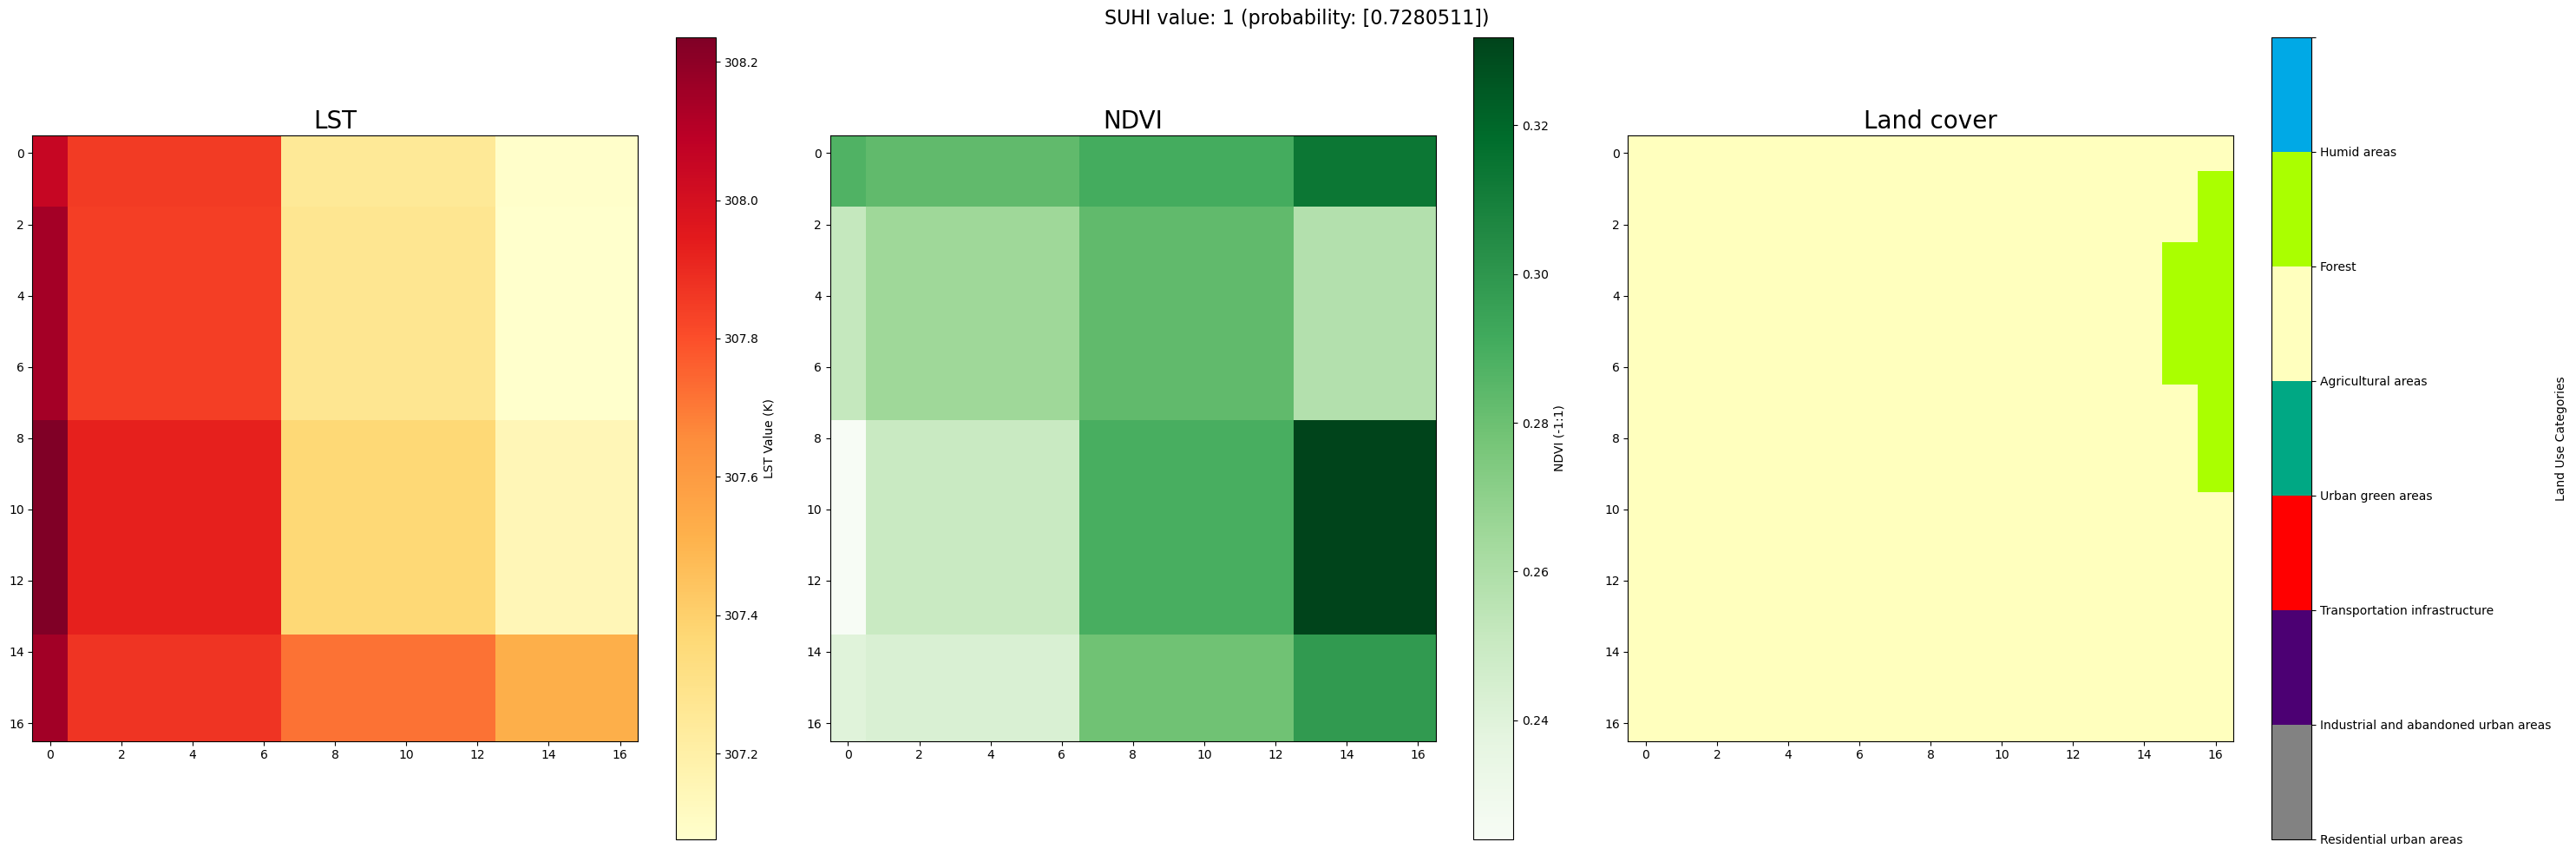

In [21]:
# Select a random index for the sample
random_idx = random.randint(0, len(X_test) - 1)

plot_bands_per_result(random_idx)

# SHAP explanations

In [22]:
bands = {
    1: 'LST',
    2: 'NDVI',
    3: 'Blue',
    4: 'Green',
    5: 'Red',
    6: 'Infrared',
    7: 'Land cover'
}
band_names = ['LST','NDVI','Blue','Green','Red','Infrared','Land cover']

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


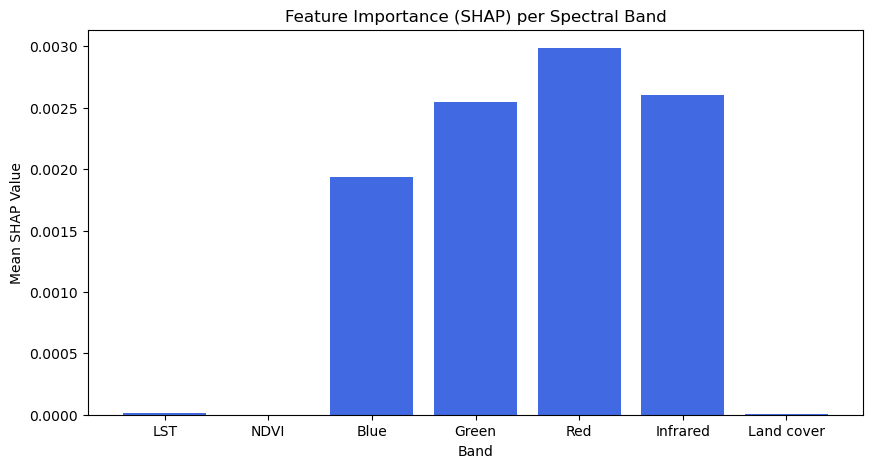

In [23]:
# Use a subset of training data as the background sample
X_background = X_train[:50]  # 50 samples for efficiency

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, X_background)

# Compute SHAP values for test samples
shap_values_ = explainer.shap_values(X_test[:50])  # Explain 10 test samples

# Convert SHAP values to numpy array for easy processing
shap_values = np.array(shap_values_)  # Shape: (1, 10, 33, 33, 7)

# -------------------------------
# 🟢 GLOBAL EXPLANATION (Summary Plot)
# -------------------------------
# Compute the mean absolute SHAP value across spatial dimensions
shap_mean = np.abs(shap_values[0]).mean(axis=(0, 1, 2))  # Shape: (7,)

# Create a summary plot (bar chart for feature importance)
plt.figure(figsize=(10, 5))
plt.bar(band_names, shap_mean, color="royalblue")  # Now correctly shaped
plt.xticks(range(7), band_names)
plt.xlabel("Band")
plt.ylabel("Mean SHAP Value")
plt.title("Feature Importance (SHAP) per Spectral Band")
plt.show()

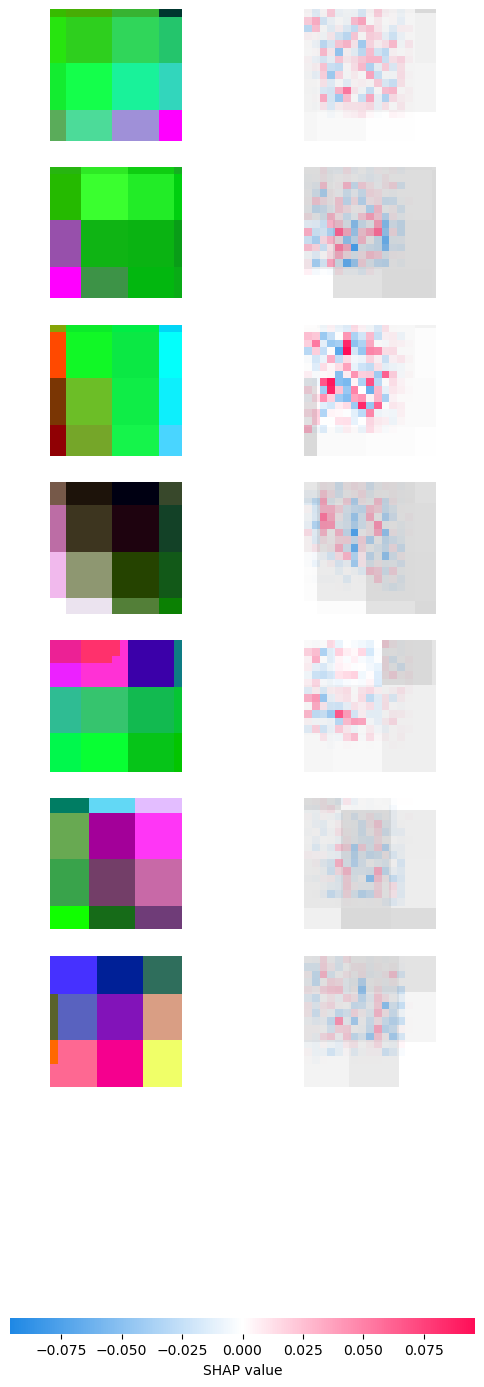

In [86]:
shap.image_plot(shap_values_, X_test[1:8])

In [54]:
 X_test[:5].shape#shap_values[:1,:1,:1,:1]

(5, 17, 17, 7)

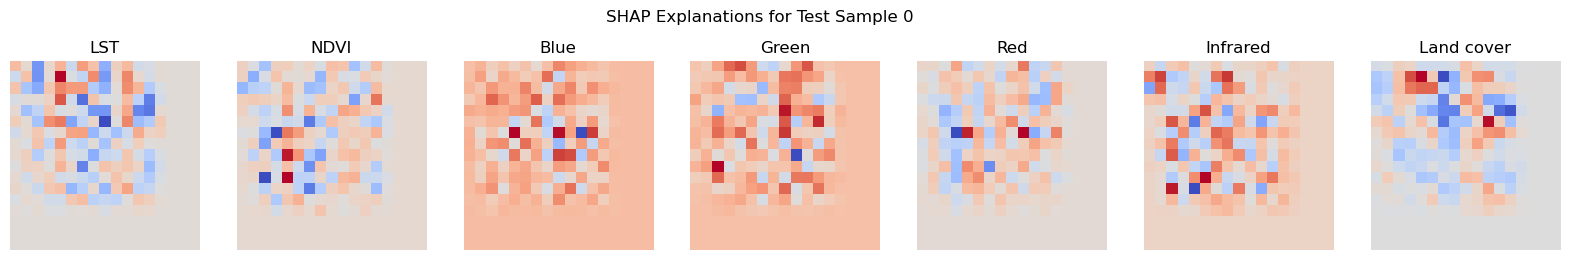

In [55]:
# Select a single test sample for visualization
sample_idx = 0
shap_single = shap_values[0][sample_idx]  # Shape: (33, 33, 7)

# Plot SHAP values for each band as a heatmap
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
for i in range(7):
    ax = axes[i]
    ax.imshow(shap_single[:, :, i], cmap="coolwarm", interpolation="nearest")
    ax.set_title(band_names[i])  # Use band names as titles
    ax.axis("off")

plt.suptitle(f"SHAP Explanations for Test Sample {sample_idx}")
plt.show()

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_shap(sample_idx):
    # Select a single test sample for visualization
    #sample_idx = 2
    shap_single = shap_values[0][sample_idx]  # SHAP values (33, 33, 7)
    original_sample = X_test[sample_idx]  # Original band values (33, 33, 7)

    # Get model prediction for this sample
    predicted_uhi = model.predict(X_test[sample_idx].reshape(1, patch_size, patch_size, 7))[0, 0]  
    uhi_class = 1 if predicted_uhi >= 0.5 else 0  # Convert probability to class



    # Create the first figure for original bands (top row)
    fig_orig, axes_orig = plt.subplots(1, 7, figsize=(20, 6))
    fig_orig.subplots_adjust(hspace=0.4)

    # Colormap for original data
    cmap_orig = "viridis"  # Suitable for satellite imagery

    for i in range(7):
        # Original band (top row)
        ax_orig = axes_orig[i]
        im_orig = ax_orig.imshow(original_sample[:, :, i], cmap=cmap_orig, interpolation="nearest")
        ax_orig.set_title(band_names[i])
        
        # Create a divider for the axis and add a color bar
        divider = make_axes_locatable(ax_orig)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_orig, cax=cax)

    # Add a main title for the original bands
    fig_orig.suptitle(
        f"Original Bands for Test Sample {sample_idx}\n"
        f"Predicted UHI Class: {uhi_class} (Probability: {predicted_uhi:.2f})",
        fontsize=14
    )

    # Create the second figure for SHAP values (bottom row)
    fig_shap, axes_shap = plt.subplots(1, 7, figsize=(20, 6))
    fig_shap.subplots_adjust(hspace=0.4)

    # Colormap for SHAP values
    cmap_shap = "coolwarm"  # For positive/negative impact visualization

    for i in range(7):
        # SHAP values (bottom row)
        ax_shap = axes_shap[i]
        im_shap = ax_shap.imshow(shap_single[:, :, i], cmap=cmap_shap, interpolation="nearest")
        ax_shap.axis("off")

    # Add horizontal colorbar for SHAP values at the bottom
    cbar_ax_shap = fig_shap.add_axes([0.1, 0.05, 0.8, 0.03])  # Position for horizontal colorbar
    fig_shap.colorbar(im_shap, cax=cbar_ax_shap, orientation='horizontal').set_label("SHAP Value (Impact on UHI)")

    # Add a main title for SHAP values
    fig_shap.suptitle(
        f"SHAP Explanations for Test Sample {sample_idx}\n"
        f"Predicted UHI Class: {uhi_class} (Probability: {predicted_uhi:.2f})",
        fontsize=14
    )

    # Show the plots vertically with adjusted colorbar
    fig_orig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title to avoid overlap
    fig_shap.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title to avoid overlap
    plt.show()

    # -----------------------------------------
    # 🔹 Explanation Guide for Interpretation
    # -----------------------------------------
    print(
        "Top row: Original spectral bands (LST, NDVI, etc.).\n"
        "Bottom row: SHAP explanations (how much each pixel influences the UHI probability).\n"
        "Red (SHAP plot): Increases probability of High UHI.\n"
        "Blue (SHAP plot): Decreases probability of High UHI.\n"
        "Compare with the top row: See how certain areas of the original image drive predictions."
    )


1/1 [==============================] - 0s 11ms/step


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


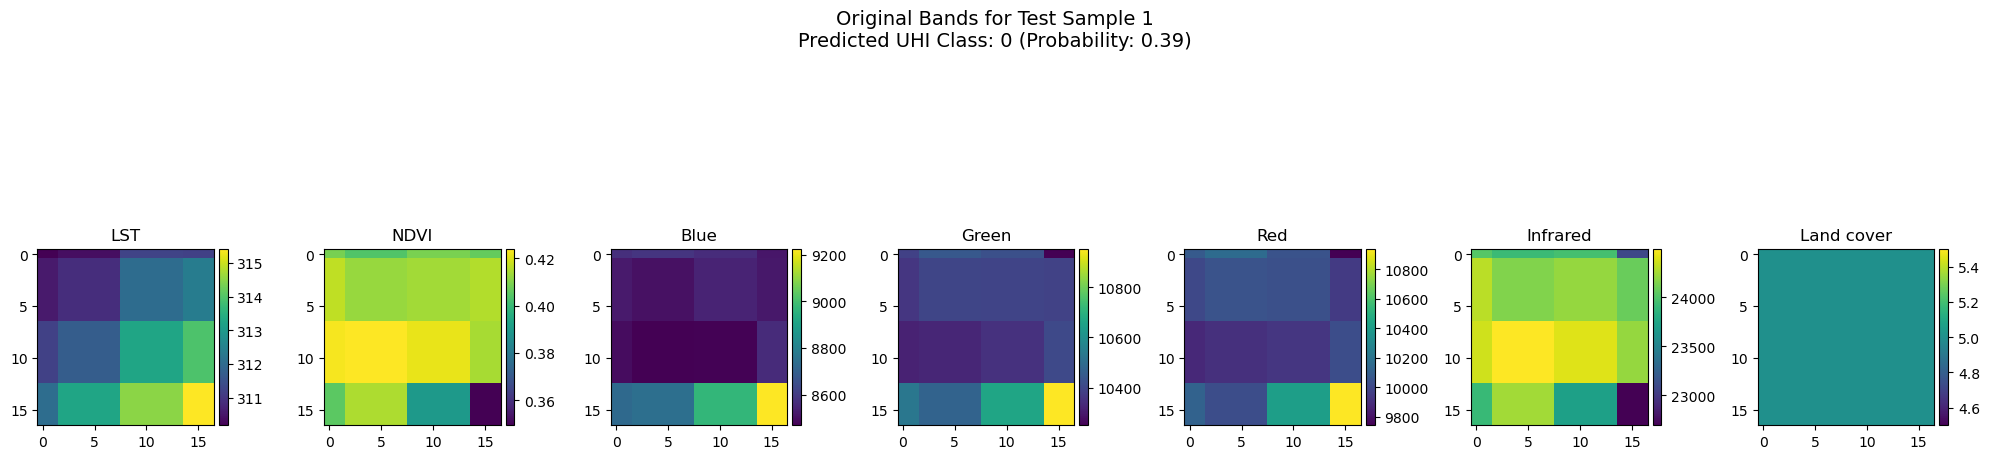

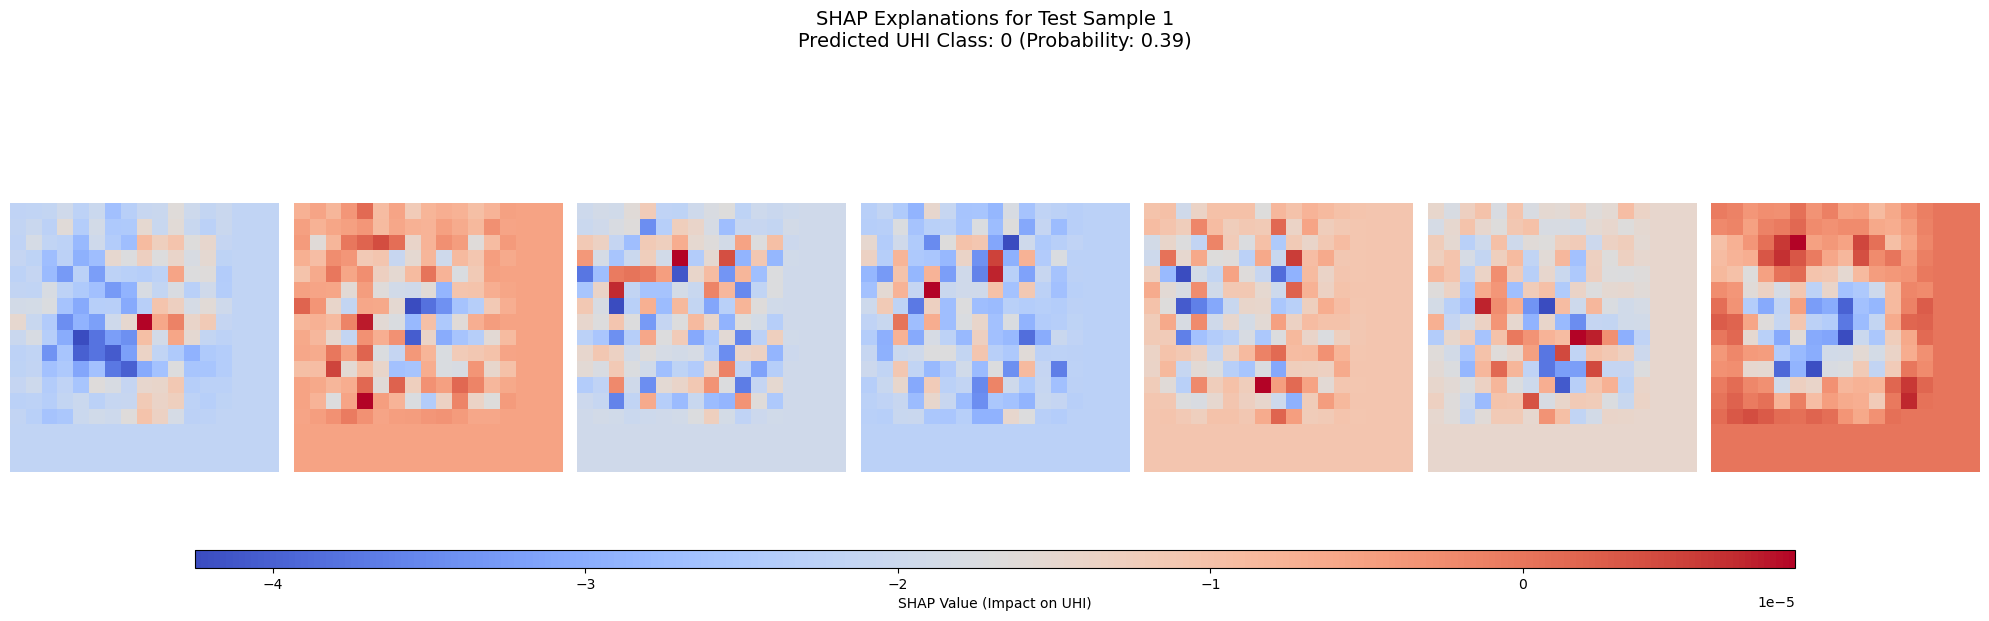

Top row: Original spectral bands (LST, NDVI, etc.).
Bottom row: SHAP explanations (how much each pixel influences the UHI probability).
Red (SHAP plot): Increases probability of High UHI.
Blue (SHAP plot): Decreases probability of High UHI.
Compare with the top row: See how certain areas of the original image drive predictions.


In [28]:
sample_idx = 1
plot_shap(sample_idx)

In [29]:
# Get absolute mean SHAP values per band
shap_single = shap_values[0][sample_idx] 
shap_means = np.mean(np.abs(shap_single), axis=(0, 1))  # Average absolute SHAP values

# Normalize relative to the max SHAP impact
max_shap = np.max(shap_means) if np.max(shap_means) > 0 else 1  # Avoid division by zero
normalized_shap = shap_means / max_shap  # Scale SHAP values between 0 and 1

# Define new impact levels dynamically
impact_levels = []
for value in normalized_shap:
    if value > 0.75:
        impact_levels.append("🔴 Strong")
    elif value > 0.5:
        impact_levels.append("🟠 Moderate")
    elif value > 0.25:
        impact_levels.append("🟡 Weak")
    else:
        impact_levels.append("⚪ Negligible")  # Below 25% of max impact

# Print results
for i, band in enumerate(band_names):
    print(f"**{band}**: Normalized Impact = {normalized_shap[i]:.2f} → {impact_levels[i]}")


**LST**: Normalized Impact = 0.00 → ⚪ Negligible
**NDVI**: Normalized Impact = 0.00 → ⚪ Negligible
**Blue**: Normalized Impact = 0.63 → 🟠 Moderate
**Green**: Normalized Impact = 0.76 → 🔴 Strong
**Red**: Normalized Impact = 0.79 → 🔴 Strong
**Infrared**: Normalized Impact = 1.00 → 🔴 Strong
**Land cover**: Normalized Impact = 0.00 → ⚪ Negligible


In [ ]:
#To be done ... it is missing the input to be flatten

layer = model.get_layer("conv2d_1")  # Choose a convolutional layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)

# Get intermediate activations
activations = intermediate_model.predict(X_test[:10])

# Apply SHAP on these activations
explainer = shap.Explainer(intermediate_model, X_train[:100])
shap_values = explainer(activations)

shap.summary_plot(shap_values, activations)